In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import pickle
import os

In [2]:
newpath = os.path.join('.', 'pkls')
if not os.path.exists(newpath):
    os.makedirs(newpath)

## Read the dataset and make some cleaning

In [3]:
df = pd.read_csv('Reviews.csv')

In [4]:
df_scores = df.Score.value_counts().to_frame().reset_index()
df_scores.columns = ['Rating', 'Size']

Text(0.5,1,'Distribution of Ratings')

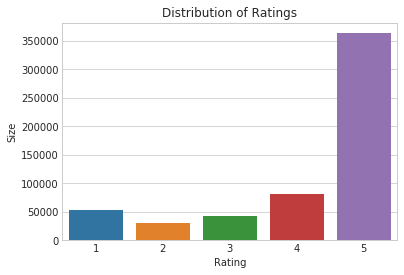

In [5]:
sns.set_style("whitegrid")
ax = sns.barplot(x='Rating', y='Size', data=df_scores)
ax.set_title('Distribution of Ratings')

In [6]:
df.head().Text.values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [7]:
df['Text'] = df.Text.str.lower().replace('[\.,&;\(\)]', '')

## Checking if any null texts occurrs

In [8]:
df.Text.isnull().any()

False

## Filtering and getting only columns that will be used here

In [9]:
df = df[['Text', 'Score']]
df = df.rename(columns={'Score': 'target'})
df.shape

(568454, 2)

## Changing targets

In [10]:
df.target = df.target.apply(lambda x: 1 if x > 3 else 0)

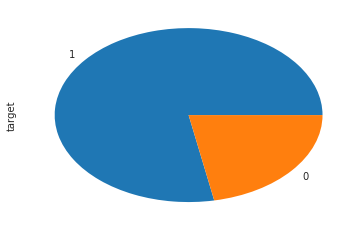

In [11]:
df.target.value_counts().plot(kind='pie');

## Split data in train and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.Text, df.target, test_size=0.33, random_state=1955, stratify=df.target)

## Transform Train using TF-IDF

In [13]:
count_vect = CountVectorizer(stop_words='english', ngram_range=(1,3), max_df=0.9, min_df=0.1)
X_train_counts = count_vect.fit_transform(X_train.to_frame()['Text'])
X_train_counts.shape

(380864, 26)

In [14]:
count_vect.transform(pd.Series('heros'))

<1x26 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [15]:
pickle.dump(count_vect, open('pkls/count_vectorizer.pkl', 'wb'))

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tfidf = tf_transformer.transform(X_train_counts)
X_train_tfidf.shape

(380864, 26)

In [17]:
pickle.dump(tf_transformer, open('pkls/tf_transformer.pkl', 'wb'))

## Train the model

In [18]:
clfc = RandomForestClassifier(n_estimators=7, max_depth=3, n_jobs=-1)
clfc.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
pickle.dump(clfc, open('pkls/model.pkl', 'wb'))

## Transform the test

In [20]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tf_transformer.transform(X_test_counts)
X_test_tfidf.shape

(187590, 26)

In [21]:
y_pred = clfc.predict(X_test_tfidf)

## Evaluate the model classifier

In [22]:
f1_score(y_test, y_pred)

0.8768310097384421